# 1. Modelado y cuadrados mínimos

En esta primera parte buscamos ajustar un modelo cuadrático de la forma:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2$$

a los datos experimentales:

$$(x_i, y_i) = \{(0,1), (1,2), (2,2.8), (3,3.6), (4,4.5)\}.$$

Para ello representamos el problema en forma matricial y obtenemos las **ecuaciones normales**:

$$A^T A \, \beta = A^T y,$$

que luego resolvemos numéricamente en Python.

## b) Crear una función en Python que resuelva el sistema

En este inciso se implementa una función para resolver el sistema:

$$A^T A \, \beta = A^T y$$

sin utilizar funciones automáticas como `np.linalg.solve` o `np.linalg.lstsq`.
La resolución se realiza mediante el método de **eliminación gaussiana con pivoteo parcial** 
y **sustitución regresiva**, obteniendo los coeficientes del modelo cuadrático $\beta_0, \beta_1, \beta_2$.

In [1]:
import numpy as np

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)

    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            factor = M[i, k] / M[k, k]
            M[i, k:] -= factor * M[k, k:]
            b[i]     -= factor * b[k]

    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]

    return z

## c) Graficar los datos y la curva ajustada

A partir de los coeficientes obtenidos, la curva ajustada se define como:

$$\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2.$$

Luego se grafican los puntos originales y la curva estimada, mostrando el ajuste obtenido 
por el método de los mínimos cuadrados.

Coeficientes del modelo: [ 1.03142857  0.91714286 -0.01428571]


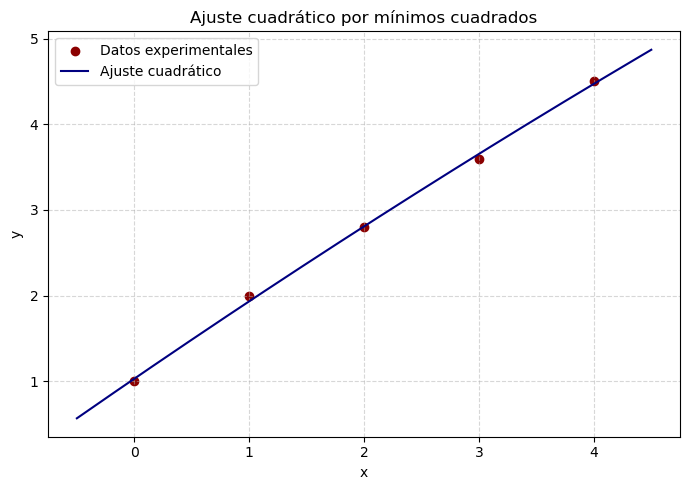

In [2]:
import matplotlib.pyplot as plt

# Datos originales
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)

# Matriz de diseño A y vectores del sistema normal
A = np.vstack([np.ones_like(x), x, x**2]).T
ATA = A.T @ A
ATy = A.T @ y

# Resolución usando la función creada
beta = gaussian_elimination_solve(ATA, ATy)
b0, b1, b2 = beta
print("Coeficientes del modelo:", beta)

# Predicción
xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = b0 + b1*xx + b2*xx**2

# Gráfico
plt.figure(figsize=(7,5))
plt.scatter(x, y, color='darkred', label='Datos experimentales')
plt.plot(xx, yy, color='navy', label='Ajuste cuadrático')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste cuadrático por mínimos cuadrados")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## d) Error cuadrático medio (MSE)

El error cuadrático medio se calcula como:

$$\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^n \big(y_i - \hat{y}(x_i)\big)^2,$$

donde $\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2$.

In [5]:
import numpy as np

y_hat = A @ beta
mse = np.mean((y - y_hat) ** 2)

print("MSE =", mse)
print("MSE (8 decimales) =", f"{mse:.8f}")

MSE = 0.001828571428571435
MSE (8 decimales) = 0.00182857


# 2. Interpretación mediante SVD

En este punto analizamos la matriz de diseño \(A\) mediante su descomposición en valores singulares (SVD):
$$A = U\,\Sigma\,V^{\top},$$
donde \(U\) y \(V\) son matrices ortogonales y \(\Sigma=\operatorname{diag}(\sigma_1,\sigma_2,\sigma_3)\) con \(\sigma_1\ge\sigma_2\ge\sigma_3>0\).

Haremos:
- verificar ortogonalidad de \(U\);
- calcular la solución por SVD: $$\hat\beta_{\text{SVD}}=V\,\Sigma^{-1}U^{\top}y;$$
- comparar con la solución por ecuaciones normales;
- evaluar condicionamiento y colinealidad.

## a) Calcular la SVD de la matriz de diseño A

Obtenemos U, Σ y Vᵀ con `numpy.linalg.svd` y mostramos los valores singulares σᵢ.

In [6]:
import numpy as np

# Datos
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)
A = np.vstack([np.ones_like(x), x, x**2]).T
    
U, S, Vt = np.linalg.svd(A, full_matrices=False)
S

array([19.62153847,  1.86319276,  0.72369934])

## b) Verificar ortogonalidad de U

Comprobamos que:

$$U^{\top} U \approx I$$

In [7]:
I = np.eye(U.shape[1])
ortho_error = np.linalg.norm(U.T @ U - I, ord=np.inf)
ortho_error

np.float64(1.4287313961837079e-15)

## c) Comparar β_SVD con ecuaciones normales

Calculamos:

$$\hat{\beta}_{SVD} = V \Sigma^{-1} U^{\top} y$$

y comparamos con la solución anterior midiendo la diferencia:

$$\|\hat{\beta}_{SVD} - \hat{\beta}\|_2$$

In [8]:
V = Vt.T
Sigma_inv = np.diag(1.0 / S)
beta_svd = V @ Sigma_inv @ U.T @ y

ATA = A.T @ A
ATy = A.T @ y

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            m = M[i, k] / M[k, k]
            M[i, k:] -= m * M[k, k:]
            b[i]     -= m * b[k]
    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]
    return z

beta_norm = gaussian_elimination_solve(ATA, ATy)

diff_norm = np.linalg.norm(beta_svd - beta_norm)
beta_svd, beta_norm, diff_norm

(array([ 1.03142857,  0.91714286, -0.01428571]),
 array([ 1.03142857,  0.91714286, -0.01428571]),
 np.float64(4.520794885096426e-15))

## d) Condicionamiento y colinealidad

El número de condición de A se calcula como:

$$\kappa_2(A) = \frac{\sigma_{max}}{\sigma_{min}}$$

y analizamos la colinealidad entre columnas usando correlaciones y ángulos.

In [9]:
cond_number = S.max() / S.min()

stds = A.std(axis=0)
mask_var = stds > 1e-12
A_var = A[:, mask_var]

corr = np.corrcoef(A_var.T) if A_var.shape[1] > 1 else np.array([[1.0]])

def angle_deg(u, v, eps=1e-12):
    u = u - u.mean()
    v = v - v.mean()
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

p = A_var.shape[1]
angles = np.full((p, p), np.nan)
for i in range(p):
    for j in range(p):
        if i != j:
            angles[i, j] = angle_deg(A_var[:, i], A_var[:, j])

cond_number, mask_var, corr, angles

(np.float64(27.112831810234834),
 array([False,  True,  True]),
 array([[1.       , 0.9589266],
        [0.9589266, 1.       ]]),
 array([[        nan, 16.47842727],
        [16.47842727,         nan]]))

# 2. Interpretación mediante SVD

Un sistema se dice mal condicionado cuando pequeñas perturbaciones en A o y provocan grandes variaciones en la solución. Este fenómeno suele deberse a la colinealidad entre las columnas de la matriz de diseño y puede analizarse mediante la descomposición en valores singulares (SVD).

## a) Calcular la SVD de la matriz de diseño A
Obtenemos U, Σ y Vᵀ mediante la función `numpy.linalg.svd` y observamos los valores singulares σᵢ.

In [10]:
import numpy as np

x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)
A = np.vstack([np.ones_like(x), x, x**2]).T

U, S, Vt = np.linalg.svd(A, full_matrices=False)
S

array([19.62153847,  1.86319276,  0.72369934])

## b) Verificar ortogonalidad de U

Comprobamos que las columnas de U son ortogonales verificando que:

$$U^{\top}U \approx I$$

In [11]:
I = np.eye(U.shape[1])
ortho_error = np.linalg.norm(U.T @ U - I, ord=np.inf)
ortho_error

np.float64(1.4287313961837079e-15)

## c) Comparar la solución obtenida por SVD con la obtenida por ecuaciones normales

Calculamos:

$$\hat{\beta}_{SVD} = V \Sigma^{-1} U^{\top} y$$

y la comparamos con la obtenida mediante ecuaciones normales.

In [12]:
V = Vt.T
Sigma_inv = np.diag(1.0 / S)
beta_svd = V @ Sigma_inv @ U.T @ y

ATA = A.T @ A
ATy = A.T @ y

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            m = M[i, k] / M[k, k]
            M[i, k:] -= m * M[k, k:]
            b[i]     -= m * b[k]
    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]
    return z

beta_norm = gaussian_elimination_solve(ATA, ATy)
diff_norm = np.linalg.norm(beta_svd - beta_norm)
beta_svd, beta_norm, diff_norm

(array([ 1.03142857,  0.91714286, -0.01428571]),
 array([ 1.03142857,  0.91714286, -0.01428571]),
 np.float64(4.520794885096426e-15))

## d) Analizar el efecto del mal condicionamiento y la colinealidad entre columnas

Calculamos el número de condición:

$$\kappa_2(A) = \frac{\sigma_{max}}{\sigma_{min}}$$

y analizamos la correlación y el ángulo entre las columnas con varianza no nula.

In [13]:
cond_number = S.max() / S.min()

stds = A.std(axis=0)
mask_var = stds > 1e-12
A_var = A[:, mask_var]

corr = np.corrcoef(A_var.T) if A_var.shape[1] > 1 else np.array([[1.0]])

def angle_deg(u, v, eps=1e-12):
    u = u - u.mean()
    v = v - v.mean()
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

p = A_var.shape[1]
angles = np.full((p, p), np.nan)
for i in range(p):
    for j in range(p):
        if i != j:
            angles[i, j] = angle_deg(A_var[:, i], A_var[:, j])

cond_number, corr, angles

(np.float64(27.112831810234834),
 array([[1.       , 0.9589266],
        [0.9589266, 1.       ]]),
 array([[        nan, 16.47842727],
        [16.47842727,         nan]]))

\section{Análisis cuadrático del error}

La función de error del modelo se define como
\[
Q(\beta)=\|A\beta - y\|^2,
\]
y puede reescribirse como la forma cuadrática
\[
Q(\beta)
= \beta^{\top}(A^{\top}A)\beta
- 2(A^{\top}y)^{\top}\beta
+ y^{\top}y.
\]

Para visualizar su geometría, fijamos el valor óptimo $\beta_0$ y evaluamos 
$Q(\beta_1,\beta_2)$ sobre una grilla en el plano $(\beta_1,\beta_2)$.  
Las curvas de nivel muestran el paraboloide convexo asociado al error y permiten identificar el mínimo global en el punto estimado por mínimos cuadrados.

La convexidad de $Q$ se verifica mediante su Hessiana:
\[
\nabla^2 Q(\beta)=2A^{\top}A,
\]
matriz simétrica y semidefinida positiva.  
Por lo tanto, el mínimo de $Q$ se alcanza exactamente en la solución que satisface las ecuaciones normales:
\[
A^{\top}A\,\hat\beta = A^{\top}y.
\]


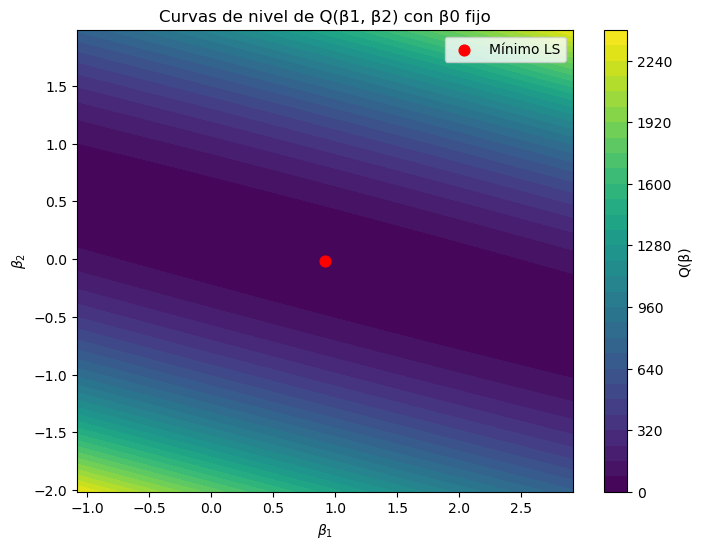

array([770.00954402,   6.94297451,   1.04748147])

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Aseguramos que beta_hat esté definido
beta_hat = beta

beta0_fijo = beta_hat[0]

b1_vals = np.linspace(beta_hat[1] - 2, beta_hat[1] + 2, 150)
b2_vals = np.linspace(beta_hat[2] - 2, beta_hat[2] + 2, 150)


B1, B2 = np.meshgrid(b1_vals, b2_vals)
Q_vals = np.zeros_like(B1)

# Evaluamos Q(beta)=||A beta - y||^2 en cada punto
for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        beta_tmp = np.array([beta0_fijo, B1[i,j], B2[i,j]])
        resid = A @ beta_tmp - y
        Q_vals[i,j] = resid @ resid

# Gráfico de curvas de nivel
plt.figure(figsize=(8,6))
cont = plt.contourf(B1, B2, Q_vals, levels=30, cmap="viridis")
plt.colorbar(cont, label="Q(β)")
plt.scatter(beta_hat[1], beta_hat[2], c="red", s=60, label="Mínimo LS")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Curvas de nivel de Q(β1, β2) con β0 fijo")
plt.legend()
plt.show()

# Verificación de convexidad mediante autovalores
H = 2 * (A.T @ A)      # Hessiana
eigvals = np.linalg.eigvals(H)
eigvals


### 3.b Convexidad de \(Q(\beta)\) y mínimo de mínimos cuadrados

La función de error del modelo puede escribirse como
\[
Q(\beta) = \|A\beta - y\|^2 
= \beta^{\top}(A^{\top}A)\beta - 2(A^{\top}y)^{\top}\beta + y^{\top}y.
\]

Su gradiente y su Hessiana son
\[
\nabla Q(\beta) = 2A^{\top}(A\beta - y), 
\qquad
\nabla^2 Q(\beta) = 2A^{\top}A.
\]

Como \(A^{\top}A\) es simétrica y semidefinida positiva, \(\nabla^2 Q(\beta)\) es positiva semidefinida y por lo tanto
\(Q(\beta)\) es una función convexa.  
El mínimo global se alcanza donde el gradiente se anula:
\[
\nabla Q(\beta) = 0 
\;\Longrightarrow\;
A^{\top}A\,\beta = A^{\top}y,
\]
es decir, en la misma solución de mínimos cuadrados obtenida a partir de las ecuaciones normales.
A continuación verificamos numéricamente estos hechos calculando los autovalores de la Hessiana y el gradiente en \(\hat\beta\).


In [16]:
import numpy as np

# Hessiana de Q(beta): H = 2 A^T A
H = 2 * (A.T @ A)

# Autovalores de la Hessiana (deben ser >= 0 si Q es convexa)
eigvals = np.linalg.eigvals(H)
print("Autovalores de la Hessiana:", eigvals)

# Gradiente de Q(beta) = 2 A^T (A beta - y)
grad_beta_hat = 2 * A.T @ (A @ beta_hat - y)
print("Gradiente en beta_hat:", grad_beta_hat)


Autovalores de la Hessiana: [770.00954402   6.94297451   1.04748147]
Gradiente en beta_hat: [-2.22044605e-15 -9.76996262e-15 -2.22044605e-14]


## 4. Optimización numérica: descenso por gradiente

En esta sección implementamos el método de **descenso por gradiente** para minimizar
\[
Q(\beta)=\|A\beta - y\|^2,
\]
cuya derivada viene dada por
\[
\nabla Q(\beta)=2A^{\top}(A\beta - y).
\]

Partimos de un valor inicial \(\beta^{(0)}\) y actualizamos iterativamente
\[
\beta^{(k+1)} = \beta^{(k)} - \eta \,\nabla Q(\beta^{(k)}),
\]
donde \(\eta>0\) es la tasa de aprendizaje.  
El algoritmo se detiene cuando la norma del gradiente es suficientemente pequeña
(o cuando se alcanza un número máximo de iteraciones).  
Al final comparamos la solución obtenida con la de mínimos cuadrados \(\hat\beta\).


β obtenido por gradiente: [ 1.03142858  0.91714285 -0.01428571]
β obtenido por mínimos cuadrados: [ 1.03142857  0.91714286 -0.01428571]
||β_gd - β_hat||_2 = 9.54461726675902e-09
Iteraciones usadas: 15289


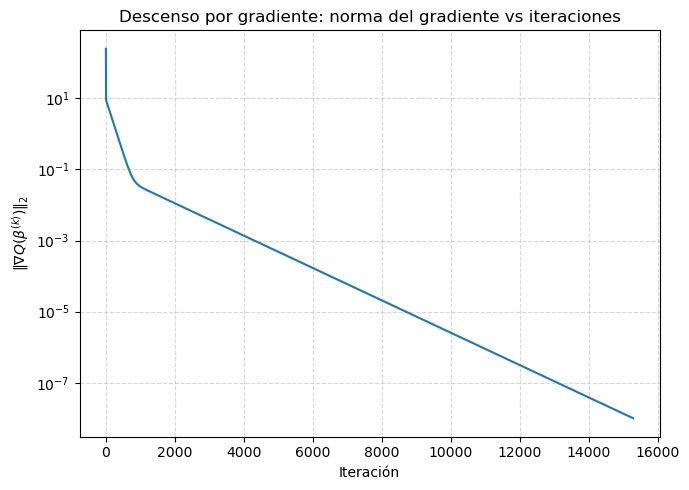

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent_Q(A, y, beta0, lr=1e-3, tol=1e-8, max_iter=100000):
    """
    Descenso por gradiente para minimizar Q(beta) = ||A beta - y||^2.
    Devuelve la beta final, el historial de normas del gradiente y
    la cantidad de iteraciones usadas.
    """
    beta = beta0.astype(float).copy()
    grad_norm_history = []

    for k in range(max_iter):
        # grad Q(beta) = 2 A^T (A beta - y)
        grad = 2 * A.T @ (A @ beta - y)
        grad_norm = np.linalg.norm(grad)
        grad_norm_history.append(grad_norm)

        if grad_norm < tol:
            break

        beta = beta - lr * grad

    return beta, np.array(grad_norm_history), k + 1

# Vector inicial (por ejemplo, todo ceros)
beta0 = np.zeros_like(beta_hat)

# Probamos una tasa de aprendizaje
beta_gd, grad_hist, iters = gradient_descent_Q(A, y, beta0, lr=1e-3, tol=1e-8, max_iter=100000)

print("β obtenido por gradiente:", beta_gd)
print("β obtenido por mínimos cuadrados:", beta_hat)
print("||β_gd - β_hat||_2 =", np.linalg.norm(beta_gd - beta_hat))
print("Iteraciones usadas:", iters)

# Gráfico de la norma del gradiente en función de las iteraciones
plt.figure(figsize=(7,5))
plt.semilogy(grad_hist)
plt.xlabel("Iteración")
plt.ylabel(r"$\|\nabla Q(\beta^{(k)})\|_2$")
plt.title("Descenso por gradiente: norma del gradiente vs iteraciones")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 4.b Experimentos con tasas de aprendizaje y tolerancias

El comportamiento del descenso por gradiente depende fuertemente de la **tasa de aprendizaje** \(\eta\) 
y de la **tolerancia** del criterio de corte.

Si \(\eta\) es demasiado pequeña, el método converge pero lo hace muy lento;  
si \(\eta\) es demasiado grande, las iteraciones pueden oscilar o incluso divergir.  
Por otro lado, tolerancias más exigentes (por ejemplo, \(10^{-8}\) en lugar de \(10^{-4}\)) 
requieren más iteraciones pero producen soluciones más cercanas a \(\hat\beta\).

A continuación comparamos el método para distintos valores de \(\eta\) y \(\text{tol}\), 
registrando:
- la cantidad de iteraciones,
- la norma del gradiente final,
- y la distancia \(\|\beta_{\text{GD}} - \hat\beta\|_2\) respecto de la solución de mínimos cuadrados.


C:\Users\46288381\AppData\Local\Temp\ipykernel_5280\3650321294.py:15: RuntimeWarning: overflow encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)
C:\Users\46288381\AppData\Local\Temp\ipykernel_5280\3650321294.py:15: RuntimeWarning: invalid value encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)


lr		 tol		 iters	 grad_final		 ||beta_gd - beta_hat||
1e-04	 1e-04	  65028	 9.999e-05	 9.546e-05
1e-04	 1e-06	 100000	 2.564e-06	 2.448e-06
1e-04	 1e-08	 100000	 2.564e-06	 2.448e-06
1e-03	 1e-04	   6501	 9.995e-05	 9.542e-05
1e-03	 1e-06	  10895	 9.997e-07	 9.543e-07
1e-03	 1e-08	  15289	 9.998e-09	 9.545e-09
5e-03	 1e-04	 100000	 nan	 nan
5e-03	 1e-06	 100000	 nan	 nan
5e-03	 1e-08	 100000	 nan	 nan
1e-02	 1e-04	 100000	 nan	 nan
1e-02	 1e-06	 100000	 nan	 nan
1e-02	 1e-08	 100000	 nan	 nan


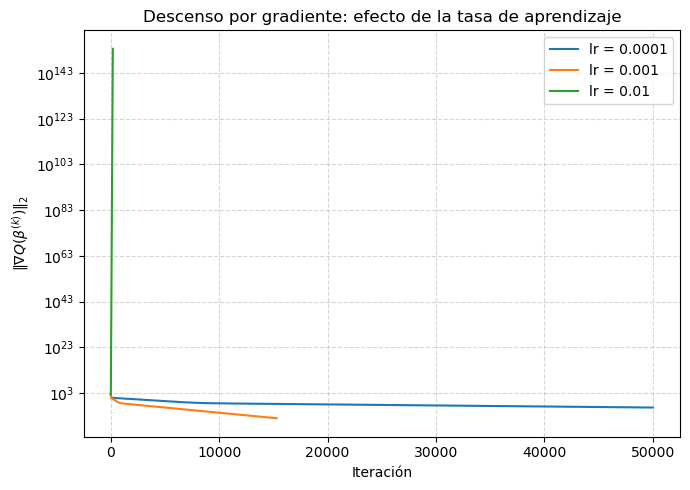

In [18]:
# Valores de tasa de aprendizaje y tolerancia a probar
lrs = [1e-4, 1e-3, 5e-3, 1e-2]
tols = [1e-4, 1e-6, 1e-8]

resultados = []

for lr in lrs:
    for tol in tols:
        beta0 = np.zeros_like(beta_hat)
        beta_gd, grad_hist, iters = gradient_descent_Q(
            A, y, beta0,
            lr=lr,
            tol=tol,
            max_iter=100000
        )
        dist = np.linalg.norm(beta_gd - beta_hat)
        grad_final = grad_hist[-1]
        resultados.append((lr, tol, iters, grad_final, dist))

# Mostrar resultados en forma más legible
print("lr\t\t tol\t\t iters\t grad_final\t\t ||beta_gd - beta_hat||")
for lr, tol, iters, grad_final, dist in resultados:
    print(f"{lr:.0e}\t {tol:.0e}\t {iters:6d}\t {grad_final:.3e}\t {dist:.3e}")

# (Opcional) comparar visualmente la convergencia para distintas lr
plt.figure(figsize=(7,5))
for lr in [1e-4, 1e-3, 1e-2]:
    beta0 = np.zeros_like(beta_hat)
    beta_gd, grad_hist, iters = gradient_descent_Q(
        A, y, beta0,
        lr=lr,
        tol=1e-8,
        max_iter=50000
    )
    plt.semilogy(grad_hist, label=f"lr = {lr}")

plt.xlabel("Iteración")
plt.ylabel(r"$\|\nabla Q(\beta^{(k)})\|_2$")
plt.title("Descenso por gradiente: efecto de la tasa de aprendizaje")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
